## Import libraries and datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from apyori import apriori
from sklearn import model_selection 
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
import numpy as np
from sklearn.cluster import KMeans,AgglomerativeClustering, DBSCAN
from sklearn import preprocessing
import pylab as pl
from sklearn import decomposition
from pprint import pprint
from sklearn.metrics import silhouette_samples, silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import dendrogram, linkage  
from pandas.plotting import scatter_matrix
import seaborn as sns
from scipy import stats
import urllib
import urllib.request
import requests
import json
from urllib.request import urlopen
from pandas import DataFrame
from pandas import merge
from sklearn.linear_model import LinearRegression

C:\Users\shera\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\shera\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\shera\AppData\Roaming\Python\Python36\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
cancer = pd.read_csv('cancer_clean.txt',sep=',')
water = pd.read_csv('water_clean.txt',sep=',')
air = pd.read_csv('air_clean.txt',sep=',')

## Exploratory Data Analysis

FIPS (unique US county code) is a common variable used to combie datasets. 

In [3]:
# add leading 0's
cancer['FIPS'] = cancer['FIPS'].apply(lambda x: '{0:0>5}'.format(x))

water['FIPS'] = water['FIPS'].apply(lambda x: '{0:0>5}'.format(x))
water['FIPS'] = water['FIPS'].astype(object)

#combine FIPS state and country to create a single FIPS column with similar format 
air['FIPS'] = air['FIPS State'] + air['FIPS County']
air = air.drop(['FIPS State', 'FIPS County'], axis=1)
air['FIPS'] = air['FIPS'].str.replace("=", "")
air['FIPS'] = air['FIPS'].str.replace("\"", "")


Add a category variable for cancer rate for future analysis.

In [4]:
def cancerBin(cancer):
    #bin cancer incidence rate
    quants = [0, .25, .5, .75, 1.]
    labels = ['<25%', '25-50%', '50-75%', '75-100%']
    cancer['Incidence Quant'] = pd.qcut(pd.to_numeric(cancer[
           'Age-Adjusted Incidence Rate(†) - cases per 100,000'],
       errors = 'coerce'),quants, labels=labels)
    return cancer

cancer = cancerBin(cancer)

In [5]:
cancer.head()

,County,FIPS,"Age-Adjusted Incidence Rate(†) - cases per 100,000",Lower 95% Confidence Interval,Upper 95% Confidence Interval,Average Annual Count,Recent Trend,Recent 5-Year Trend (‡) in Incidence Rates,Lower 95% Confidence Interval.1,Upper 95% Confidence Interval.1,Category,Group,State,SEER,NPCR,Incidence Quant
0,Union County,12125,1195.2,1119.6,1274.8,210.0,falling,-7.0,-10.5,-3.3,All,Total,Florida,6,10.0,75-100%
1,Powell County,21197,669.9,609.5,734.8,96.0,stable,1.5,0.0,3.0,All,Total,Kentucky,7,8.0,75-100%
2,Thomas County,31171,669.3,448.9,971.5,7.0,falling,-12.2,-22.4,-0.8,All,Total,Nebraska,6,10.0,75-100%
3,Logan County,31113,647.5,423.9,950.0,6.0,stable,-1.9,-46.4,79.7,All,Total,Nebraska,6,10.0,75-100%
4,Sheridan County,38083,630.8,464.6,845.0,14.0,stable,-8.8,-35.0,28.1,All,Total,North Dakota,6,10.0,75-100%


Cancer data are divided by race. Lung cancer is included becuase it is highly related to water and air qualities. 

In [6]:
pd.crosstab(cancer.Category,cancer.Group)


Group,Asian or Pacific Islander (include,Asian or Pacific Islander (includes Hispanic),Black (includes Hispanic),Lung Cancer,Total,White Hispanic,White Non-Hispanic
Category,,,,,,,
All,0,0,0,0,3141,0,0
Cancer Type,0,0,0,3141,0,0,0
Race/Ethnicity,1,688,3141,0,0,3141,3140


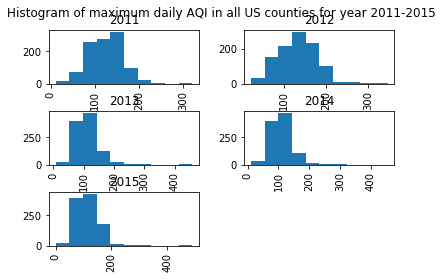

In [7]:
##This function creates a histogram showing the frequency of max AQI values for 2011-2015
##The higher the AQI value, the greater the level of air pollution and the greater the health concern.
def AirQualityHist(data):
    name= "Maximum AQI Values in the US by Year"
    data['Max AQI'].hist(by=data['Year'])
    plt.suptitle("Histogram of maximum daily AQI in all US counties for year 2011-2015")
    plt.savefig(name)
    
    plt.show()

AirQualityHist(air)

In [8]:
pd.set_option('max_columns',32 )

air.head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10,Good Days_Norm,Moderate Days_Norm,Unhealthy for Sensitive Groups Days_Norm,Unhealthy Days_Norm,Very Unhealthy Days_Norm,Hazardous Days_Norm,Days CO_Norm,Days NO2_Norm,Days Ozone_Norm,Days SO2_Norm,Days PM2.5_Norm,Days PM10_Norm,FIPS
0,Alabama,Baldwin,2015,264,230,33,1,0,0,0,129,53,38,0,0,189,0,75,0,0.871212,0.125000,0.003788,0.0,0.0,0.0,0.0,0.0,0.715909,0.0,0.284091,0.0,01003
1,Alabama,Clay,2015,112,101,11,0,0,0,0,91,50,32,0,0,0,0,112,0,0.901786,0.098214,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,01027
2,Alabama,Colbert,2015,280,251,29,0,0,0,0,73,51,36,0,0,195,0,85,0,0.896429,0.103571,0.000000,0.0,0.0,0.0,0.0,0.0,0.696429,0.0,0.303571,0.0,01033
3,Alabama,De Kalb,2015,363,319,43,1,0,0,0,101,52,37,0,0,307,0,56,0,0.878788,0.118457,0.002755,0.0,0.0,0.0,0.0,0.0,0.845730,0.0,0.154270,0.0,01049
4,Alabama,Elmore,2015,233,223,9,1,0,0,0,115,47,35,0,0,233,0,0,0,0.957082,0.038627,0.004292,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.000000,0.0,01051


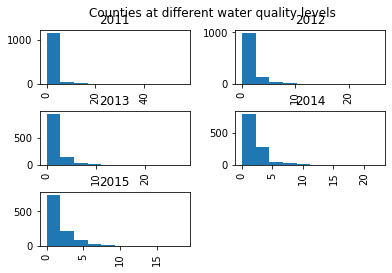

In [9]:
##This function creates a histogram showing the frequency of water quality levels
def waterQualityHist(result):
    name = "Number of counties at different water quality levels"
    result['Value'].hist(by=result['Year'])
    plt.suptitle("Counties at different water quality levels")
    plt.savefig(name)
    plt.show()

waterQualityHist(water) 

In [10]:
water['Quality'].value_counts()

Less than or equal MCL    3031
Non Detect                2771
More than MCL               80
Name: Quality, dtype: int64

In [11]:
water.head()

,Year,FIPS,Value,County,State,Quality
0,2011,45001,2.5,Abbeville,SC,Less than or equal MCL
1,2012,45001,2.5,Abbeville,SC,Less than or equal MCL
2,2013,45001,2.5,Abbeville,SC,Less than or equal MCL
3,2014,45001,2.5,Abbeville,SC,Less than or equal MCL
4,2015,45001,2.5,Abbeville,SC,Less than or equal MCL


Summary statistics for air quality. 

<img src="AQI.PNG">

In [12]:
#This function describes the mean, median and std for 5 attributes in the air quality dataset
def AirQualitymeans(data):
    
    
    Max_AQI_mean = data['Max AQI'].mean()
    Max_AQI_med = data['Max AQI'].median()
    Max_AQI_std = data['Max AQI'].std()
    
    Good_mean = data['Good Days_Norm'].mean()
    Good_med = data['Good Days_Norm'].median()
    Good_std = data['Good Days_Norm'].std()
    
    Mod_mean = data['Moderate Days_Norm'].mean()
    Mod_med = data['Moderate Days_Norm'].median()
    Mod_std = data['Moderate Days_Norm'].std()
    
    UHFSG_mean = data['Unhealthy for Sensitive Groups Days_Norm'].mean()
    UHFSG_med = data['Unhealthy for Sensitive Groups Days_Norm'].median()
    UHFSG_std = data['Unhealthy for Sensitive Groups Days_Norm'].std()
    
    Haz_mean =data['Hazardous Days_Norm'].mean()
    Haz_med = data['Hazardous Days_Norm'].median()
    Haz_std = data['Hazardous Days_Norm'].std()

    name= "Percentage of Good Days"
    data['Good Days_Norm'].hist()
    plt.suptitle(name)
    plt.savefig(name)
    plt.close()
    
    print("The average Max AQI Value across all counties for all years is: ",
          Max_AQI_mean, "with a standard deviation of: ", Max_AQI_std)
    print("The median is: ", Max_AQI_med)

    print("\n\nThe average percentage of Good Days across all counties for all years is: ",
          Good_mean *100, "%, with a standard deviation of: ", Good_std *100, "%")
    print("The median percentage is: ", Good_med*100, "%")

    print("\n\nThe average percentage of Moderate Days across all counties for all years is: ",
          Mod_mean *100, "%, with a standard deviation of: ", Mod_std *100, "%")
    print("The median percentage is: ", Mod_med*100, "%")

    print("\n\nThe average percentage of Unhealthy for Sensitive Groups Days across all counties for all years is: ",
          UHFSG_mean *100, "%, with a standard deviation of: ", UHFSG_std *100, "%")
    print("The median percentage: ", UHFSG_med*100, "%")

    print("\n\nThe average percentage of Hazardous Days across all counties for all years is: ",
          Haz_mean *100, "%, with a standard deviation of: ", Haz_std *100, "%")
    print("The median percentage is: ", Haz_med*100, "%")

AirQualitymeans(air)

The average Max AQI Value across all counties for all years is:  117.283091048202 with a standard deviation of:  41.16867231418336
The median is:  112.0


The average percentage of Good Days across all counties for all years is:  77.29182526589649 %, with a standard deviation of:  16.382890854261312 %
The median percentage is:  80.27397260273973 %


The average percentage of Moderate Days across all counties for all years is:  20.805598646570246 %, with a standard deviation of:  14.035523255926167 %
The median percentage is:  18.63013698630137 %


The average percentage of Unhealthy for Sensitive Groups Days across all counties for all years is:  1.609232952679627 %, with a standard deviation of:  3.3902810364797142 %
The median percentage:  0.4106793496593132 %


The average percentage of Hazardous Days across all counties for all years is:  0.0014871049716460598 %, with a standard deviation of:  0.03324011895860236 %
The median percentage is:  0.0 %


Summary statistics for cancer rate. 

In [13]:
def Cancermeans(data):
    #This function describes the mean, median and std for 3 attributes in the cancer dataset
    
	AA_mean = data[['Age-Adjusted Incidence Rate(†) - cases per 100,000']][
            data['Category']=='All'].mean()
	AA_med = data[['Age-Adjusted Incidence Rate(†) - cases per 100,000']][
            data['Category']=='All'].median()
	AA_std = data[['Age-Adjusted Incidence Rate(†) - cases per 100,000']][
            data['Category']=='All'].std()
    
	Count_mean = data[['Average Annual Count']][data['Category']=='All'].mean()
	Count_med = data[['Average Annual Count']][data['Category']=='All'].median()
	Count_std = data[['Average Annual Count']][data['Category']=='All'].std()

	yr_mean = data[['Recent 5-Year Trend (‡) in Incidence Rates']][data['Category']=='All'].mean()
	yr_med = data[['Recent 5-Year Trend (‡) in Incidence Rates']][data['Category']=='All'].median()
	yr_std = data[['Recent 5-Year Trend (‡) in Incidence Rates']][data['Category']=='All'].std()

	print("The average age adjusted incidence rate across all counties for all years is: ",
       AA_mean[0], "with a standard deviation of: ", AA_std[0])
	print("The median is: ", AA_med[0])

	print("\n\nThe average annual count of new cancer cases across all counties for all years is: ",
       Count_mean[0], " with a standard deviation of: ", Count_std[0] )
	print("The median is: ", Count_med[0])

	print("\n\nThe average trend in incidence rates across all counties for all years is: ",
       yr_mean[0], "%, with a standard deviation of: ", yr_std[0], "%")
	print("The median percentage is: ", yr_med[0], "%")

Cancermeans(cancer)

The average age adjusted incidence rate across all counties for all years is:  439.8779568049349 with a standard deviation of:  57.68311729431437
The median is:  445.6


The average annual count of new cancer cases across all counties for all years is:  525.6360845839017  with a standard deviation of:  1473.511195117485
The median is:  152.0


The average trend in incidence rates across all counties for all years is:  -0.7663339070567979 %, with a standard deviation of:  4.218998396670983 %
The median percentage is:  -0.7 %


Summary statistics of concentration of arsenic in water.

In [14]:
def waterQualitymeans(result):
    #This function describes the mean, median and std for 2 attributes in the cancer dataset
    Arsenic_content_mean=statistics.mean(result['Value']) 
    Arsenic_content_median=statistics.median(result['Value']) 
    Arsenic_content_sd=statistics.stdev(result['Value']) 
    Quality_mode=statistics.mode(result['Quality'])
    print("The average Arsenic_content in water across all counties for all years is: ",
          Arsenic_content_mean, "with a standard deviation of: ", Arsenic_content_median)
    print("The median is: ", Arsenic_content_sd)
    print("The mode of water quality level is ", Quality_mode)
 
waterQualitymeans(water)

The average Arsenic_content in water across all counties for all years is:  1.880552177769952 with a standard deviation of:  1.1344927536231886
The median is:  2.389925518855463
The mode of water quality level is  Less than or equal MCL


### Association Rule

Identify interesting relationships between cancer and water & air qualities. 

In [20]:
######### ASSOCIATION RULE MINING CODE ####################################
def AssociationRuleMining(cancer, water, air):
    
    avg_value = water.groupby('FIPS', as_index=False)['Value'].mean()
    bins = [-1,1,10,60]
    labels=['Non Detect','Less than or equal MCL','More than MCL' ]
    avg_value['Quality']=pd.cut(avg_value['Value'],bins,labels=labels)
    
    #calculate norms over all time
    max_aqi = air.groupby('FIPS', as_index=False)['Max AQI'].max()
    ninetieth = air.groupby('FIPS', as_index=False)['90th Percentile AQI'].mean()
    median = air.groupby('FIPS', as_index=False)['Median AQI'].mean()
    bins = [0,50,100,150,200,300,500]
    labels=['Good Max AQI','Moderate Max AQI','Unhealthy for Sensitive Groups Max AQI','Unhealthy Max AQI',
   	'Very Unhealthy Max AQI', 'Hazardous Max AQI']
    max_aqi['Max AQI Level']=pd.cut(max_aqi['Max AQI'],bins,labels=labels)
    labels=['Good 90th','Moderate 90th','Unhealthy for Sensitive Groups 90th','Unhealthy 90th',
            'Very Unhealthy 90th', 'Hazardous 90th']
    ninetieth['90th Percentile Level(AQI)']=pd.cut(ninetieth['90th Percentile AQI'],bins,labels=labels)
    
    labels=['Good Median','Moderate Median','Unhealthy for Sensitive Groups Median','Unhealthy Median',
            'Very Unhealthy Median', 'Hazardous Median']
    median['Median Level']=pd.cut(median['Median AQI'],bins,labels=labels)
    wca = pd.merge(cancer[['FIPS', 'Recent Trend', 'Incidence Quant']][
           cancer['Category']=='All'], avg_value, on='FIPS')
    wca = pd.merge(wca, max_aqi, on='FIPS')
    wca = pd.merge(wca, ninetieth, on='FIPS')
    wca = pd.merge(wca, median, on='FIPS')
    asm = wca[['FIPS', 'Recent Trend', 'Incidence Quant', 'Quality', 'Max AQI Level', '90th Percentile Level(AQI)', 'Median Level']]
    asm = wca[['Incidence Quant', 'Quality', '90th Percentile Level(AQI)']]
    
    records = []
    for i in range(0, 599):  
        records.append([str(asm.values[i,j]) for j in range(0, 3)])

 
    results = list(apriori(records, min_support=0.0003, min_confidence=0.1, min_lift=2, min_length=2))
   
    results = list(apriori(records, min_support=0.0005, min_confidence=0.2, min_lift=2, min_length=2))
   
    results = list(apriori(records, min_support=0.001, min_confidence=0.3, min_lift=2, min_length=2))
    for item in results:
    	hypo = ''.join([x+' ' for x in item.ordered_statistics[0].items_base])
    	conc = ''.join([x+' ' for x in item.ordered_statistics[0].items_add])
    	print(str(hypo)+ " --> "+str(conc))
    	print("Support: " + str(item[1]))
    	print("Confidence: " + str(item[2][0][2]))
    	print("Lift: " + str(item[2][0][3]))
    	print("-----------------------------------")

AssociationRuleMining(cancer, water, air)

More than MCL  --> 25-50% 
Support: 0.01001669449081803
Confidence: 0.6666666666666666
Lift: 3.8770226537216823
-----------------------------------
Unhealthy for Sensitive Groups 90th  --> 25-50% 
Support: 0.01335559265442404
Confidence: 0.5333333333333333
Lift: 3.1016181229773463
-----------------------------------
Unhealthy 90th  --> More than MCL 
Support: 0.001669449081803005
Confidence: 0.33333333333333337
Lift: 22.185185185185187
-----------------------------------
More than MCL  --> Unhealthy for Sensitive Groups 90th 
Support: 0.005008347245409015
Confidence: 0.3333333333333333
Lift: 13.31111111111111
-----------------------------------
Unhealthy for Sensitive Groups 90th Less than or equal MCL  --> 25-50% 
Support: 0.00667779632721202
Confidence: 0.4444444444444444
Lift: 2.5846817691477884
-----------------------------------
More than MCL Moderate 90th  --> 25-50% 
Support: 0.00333889816360601
Confidence: 0.4
Lift: 2.32621359223301
-----------------------------------
25-50% Un

### Hypothesis test -- KNN and Decision Trees
Hypothesis → can air and water data be used to predict 5 year average age adjusted cancer incidence rates per 100,000?

In [29]:
############################################################################
######### Hypothesis test -- KNN and Decision Trees ###############################
# Hypothesis → can air and water data be used to predict 5 year average age adjusted 
# cancer incidence rates per 100,000.  

# Calculate 5-year averages for Input data.  Merging cancer data to air
# and water reduced the number of data entries.  The counties in each data
# set does not seem to be overlapping.  
median = air.groupby('FIPS', as_index=False)['Median AQI'].mean()
pm = air.groupby('FIPS', as_index=False)['Days PM2.5_Norm'].mean()
so2 = air.groupby('FIPS', as_index=False)['Days SO2_Norm'].mean()
co = air.groupby('FIPS', as_index=False)['Days CO_Norm'].mean()
no2 = air.groupby('FIPS', as_index=False)['Days NO2_Norm'].mean()
ozone = air.groupby('FIPS', as_index=False)['Days Ozone_Norm'].mean()
ar = water.groupby('FIPS', as_index=False)['Value'].mean()


dataSubset = pd.merge(median, ar, on='FIPS')
dataSubset = pd.merge(dataSubset, ozone, on='FIPS')
dataSubset = pd.merge(dataSubset, pm, on='FIPS')
# Class label.
labels = cancer[['FIPS', 'Incidence Quant']][cancer['Category']=='All']

dataSubset = pd.merge(dataSubset, labels, on='FIPS')
dataSubset = dataSubset.drop('FIPS', axis=1)
dataSubset = dataSubset.dropna()

dataSubset['Incidence Quant'] = dataSubset['Incidence Quant'].astype('category')

def evaluateKnnDecisionTree(data):
      '''Evaluates different algorithms and their effectiveness at predicting
      the diabetes dataset.  The best accuracy score should be used to classify
      the test dataset'''
      # Separate training and final validation data set. First remove class
      # label from data (X). Setup target class (Y)
      # Then make the validation set 20% of the entire
      # set of labeled data (X_validate, Y_validate)
      test_size = 0.20  # Size of the test subset is 20% of the entire dataset
      seed = 7
      valueArrayD = data.values
      #X = valueArrayD[:,0:6]
      #Y = valueArrayD[:,6]
      X = valueArrayD[:,0:4]
      Y = valueArrayD[:,4]
      X_train, X_validate, Y_train, Y_validate = \
            model_selection.train_test_split(X, Y, test_size=test_size,
                                 random_state=seed)
      # Setup -fold cross validation to estimate the accuracy of different 
      # models.
      # Split data into 10 subsets.
      # Test options and evaluation metric.
      num_folds = 10
      seed = 7
      scoring = 'accuracy'
      # Add each algorithm and its name to the model array
      models = []
      models.append(('KNN', KNeighborsClassifier()))
      models.append(('CART', DecisionTreeClassifier()))
      
      # Normalized the training input dataset.
      #X_train[:,[0,2]] = normalize(X_train[:,[0,2]])
      X_train_norm = X_train
      # Normalize test dataset.
      #X_validate[:,[0,2]] = normalize(X_validate[:,[0,2]])
      X_validate_norm = X_validate
      
      # Evaluate each model.
      # Print the accuracy results (remember these are averages and std)
      print("Results from cross validation test:")
      for name, model in models:
            kfold = model_selection.KFold(n_splits=num_folds, 
                                          random_state=seed)
            cv_results_d = model_selection.cross_val_score(model, 
                                                           X_train_norm, 
                                                           Y_train, cv=kfold,
                                                           scoring=scoring)
            # cv_results2 are the accuracy results for each of the 10 subsets
            msg_d = "%s: \t mean=%f \t standard deviation={%f)"% (name,
                                                           cv_results_d.mean(),
                                                           cv_results_d.std())
            print(msg_d)
      # Using knn for the validation test.
      knn = KNeighborsClassifier()
      knn = knn.fit(X_train_norm, Y_train)
      predictions_d = knn.predict(X_validate_norm)
      print("\nThe accuracy score, confusion matrix, and classification " +
            "report for KNN is: \n", accuracy_score(Y_validate, 
                                                    predictions_d))
      print(confusion_matrix(Y_validate, predictions_d))
      print(classification_report(Y_validate, predictions_d))
      
      # Using decision tree for the validation test.
      dtc = DecisionTreeClassifier()
      dtc = dtc.fit(X_train_norm, Y_train)
      predictions_d = dtc.predict(X_validate_norm)
      print("\nThe accuracy score, confusion matrix, and classification " +
            "report for decision tree is: \n", accuracy_score(Y_validate, 
                                                    predictions_d))
      print(confusion_matrix(Y_validate, predictions_d))
      print(classification_report(Y_validate, predictions_d))
      
evaluateKnnDecisionTree(dataSubset)

Results from cross validation test:
KNN: 	 mean=0.399495 	 standard deviation={0.091115)
CART: 	 mean=0.446414 	 standard deviation={0.067933)

The accuracy score, confusion matrix, and classification report for KNN is: 
 0.4778761061946903
[[ 8  6  3]
 [ 7 15 18]
 [ 8 17 31]]
             precision    recall  f1-score   support

     25-50%       0.35      0.47      0.40        17
     50-75%       0.39      0.38      0.38        40
    75-100%       0.60      0.55      0.57        56

avg / total       0.49      0.48      0.48       113


The accuracy score, confusion matrix, and classification report for decision tree is: 
 0.4247787610619469
[[ 6  7  4]
 [ 8 15 17]
 [ 6 23 27]]
             precision    recall  f1-score   support

     25-50%       0.30      0.35      0.32        17
     50-75%       0.33      0.38      0.35        40
    75-100%       0.56      0.48      0.52        56

avg / total       0.44      0.42      0.43       113



### Clustering Analysis

In [34]:
################################### clustering analysis########################
###############################################################################
# average water value to match the average annual cancer count
avg_value = water.groupby('FIPS', as_index=False)['Value'].mean()
# subset all type cancer
cancer_alltype = cancer.loc[cancer['Category'] == 'All']
# merge chosen columns in cancer and water avg value
cancer_water = pd.merge(cancer_alltype[['FIPS','Average Annual Count']],avg_value,on='FIPS')
### cancer data has more fips than water/avg_value
###a = cancer_alltype['FIPS']
###b = avg_value['FIPS']
#list_1 = ["a", "b", "c", "d", "e"]
#list_2 = ["a", "f", "c", "m"] 
#morecancerfips = np.setdiff1d(b,a)
avg_gooddaynorm = air.groupby('FIPS', as_index=False)['Good Days_Norm'].mean()
#c = cancer_water['FIPS']
#d = avg_gooddaynorm['FIPS']
#list_1 = ["a", "b", "c", "d", "e"]
#list_2 = ["a", "f", "c", "m"] 
#morecancerfips = np.setdiff1d(c,d)
cancer_water_air = pd.merge(cancer_water,avg_gooddaynorm,on='FIPS')



#### Hierarchical Clustering

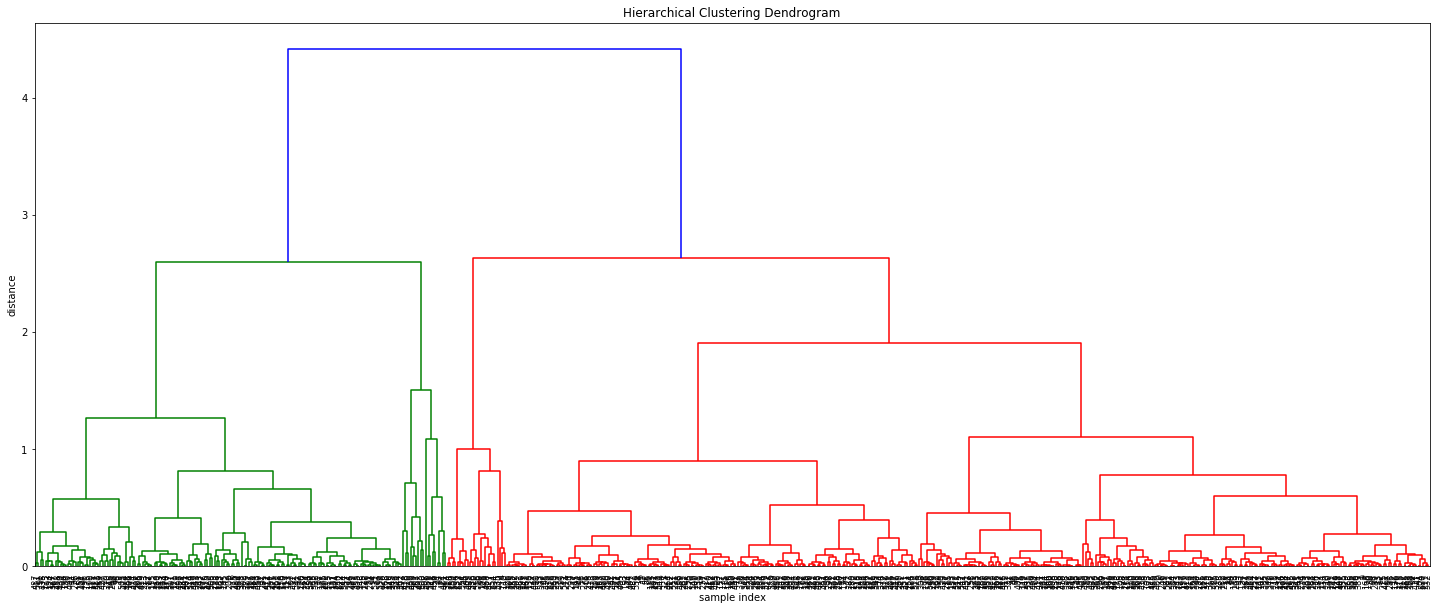

In [35]:
##### Hierarchical Clustering
def getDendrogram(cancer_water_air):
    # Remove missing data 
    cancer_water_air = cancer_water_air.dropna()
    # normalize data
    mycancer_water_air=pd.concat([cancer_water_air['Average Annual Count'], cancer_water_air['Value'], cancer_water_air['Good Days_Norm']], 
                 axis=1, keys=['Average Annual Count','Value','Good Days_Norm' ])
    x = mycancer_water_air.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    normalizedDataFrame = pd.DataFrame(x_scaled)
    normalizedDataFrame.columns = ['Average Annual Count','Value','Good Days_Norm']
    
    # generate the linkage matrix
    Z = linkage(normalizedDataFrame, 'ward')
    # calculate full dendrogram
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    )
    plt.show()
getDendrogram(cancer_water_air)

For n_clusters = 5 The average silhouette_score is : 0.31834151481648054
{0: 18, 1: 148, 2: 24, 3: 206, 4: 166}


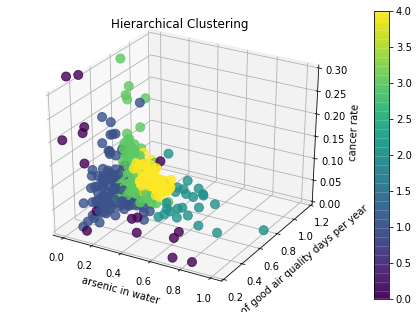

In [36]:
def Hier_clustering(cancer_water_air,k):
    # Remove missing data 
    cancer_water_air = cancer_water_air.dropna()
    # normalize data
    mycancer_water_air=pd.concat([cancer_water_air['Average Annual Count'], cancer_water_air['Value'], cancer_water_air['Good Days_Norm']], 
                 axis=1, keys=['Average Annual Count','Value','Good Days_Norm' ])
    x = mycancer_water_air.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    normalizedDataFrame = pd.DataFrame(x_scaled)
    normalizedDataFrame.columns = ['Average Annual Count','Value','Good Days_Norm']
    
    model = AgglomerativeClustering(n_clusters=k, affinity = 'euclidean', linkage = 'ward')
    clust_labels1 = model.fit_predict(normalizedDataFrame)
    agglomerative = pd.DataFrame(clust_labels1)
    
    # Determine if the clustering is good
    silhouette_avg = silhouette_score(normalizedDataFrame, clust_labels1)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)
    #centroids = model.cluster_centers_
    pprint(dict(pd.Series(clust_labels1).value_counts()))
    #pprint(centroids)
    
    # plot the clustering in 3D graph
    fig = plt.figure()
    ax = Axes3D(fig)
    scatter = ax.scatter(normalizedDataFrame['Value'],normalizedDataFrame['Good Days_Norm'],normalizedDataFrame['Average Annual Count'],
                         c=agglomerative[0],s=80,alpha=0.8)
    ax.set_title('Hierarchical Clustering')
    ax.set_xlabel('arsenic in water')
    ax.set_ylabel('rates of good air quality days per year')
    ax.set_zlabel('cancer rate')
    ax.set_zlim3d(0.0,0.3)
    ax.set_ylim3d(0.2,1.2)
    plt.colorbar(scatter)
    plt.show()
Hier_clustering(cancer_water_air,5)

#### K means Clustering

For n_clusters = 5 The average silhouette_score is : 0.3352291918376398
{0: 26, 1: 217, 2: 18, 3: 174, 4: 127}
array([[0.01576999, 0.47415892, 0.73204616],
       [0.03241138, 0.08762354, 0.7703049 ],
       [0.15864681, 0.34794162, 0.22822953],
       [0.01551727, 0.09454701, 0.9189939 ],
       [0.05113537, 0.08005536, 0.57818928]])


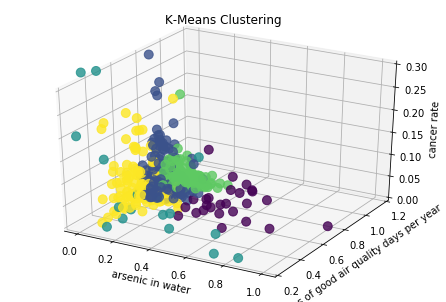

In [38]:
#####
#K means Clustering 
#####
def KMeans_cluster(cancer_water_air,k):
    # Remove missing data 
    cancer_water_air = cancer_water_air.dropna()
    # normalize data
    mycancer_water_air=pd.concat([cancer_water_air['Average Annual Count'], cancer_water_air['Value'], cancer_water_air['Good Days_Norm']], 
                 axis=1, keys=['Average Annual Count','Value','Good Days_Norm' ])
    x = mycancer_water_air.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    normalizedDataFrame = pd.DataFrame(x_scaled)
    normalizedDataFrame.columns = ['Average Annual Count','Value','Good Days_Norm']
    
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(normalizedDataFrame)

    # Determine if the clustering is good
    silhouette_avg = silhouette_score(normalizedDataFrame, cluster_labels)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)
    centroids = kmeans.cluster_centers_
    pprint(dict(pd.Series(cluster_labels).value_counts()))
    pprint(centroids)
    
    # plot the clustering in 3D graph
    kmeans = pd.DataFrame(cluster_labels)
    fig = plt.figure()
    ax = Axes3D(fig)
    scatter = ax.scatter(normalizedDataFrame['Value'],normalizedDataFrame['Good Days_Norm'],normalizedDataFrame['Average Annual Count'],
                         c=kmeans[0],s=80,alpha=0.8)
    ax.set_title('K-Means Clustering')
    ax.set_xlabel('arsenic in water')
    ax.set_ylabel('rates of good air quality days per year')
    ax.set_zlabel('cancer rate')
    ax.set_zlim3d(0.0,0.3)
    ax.set_ylim3d(0.2,1.2)
    #plt.colsorbar(scatter)
    plt.show()
KMeans_cluster(cancer_water_air,5)

#### dbscan Clustering

The average silhouette_score is : 0.5022794385425817
{-1: 77, 0: 485}


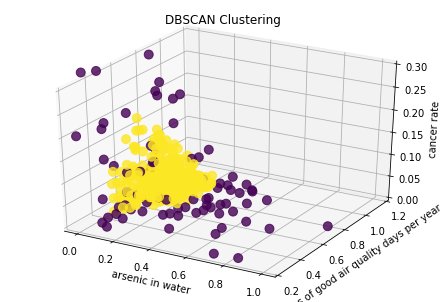

In [40]:
# dbscan clustering
def DBSCAN_clustering(cancer_water_air):
    # Remove missing data 
    cancer_water_air = cancer_water_air.dropna()
    # normalize data
    mycancer_water_air=pd.concat([cancer_water_air['Average Annual Count'], cancer_water_air['Value'], cancer_water_air['Good Days_Norm']], 
                 axis=1, keys=['Average Annual Count','Value','Good Days_Norm' ])
    x = mycancer_water_air.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    normalizedDataFrame = pd.DataFrame(x_scaled)
    normalizedDataFrame.columns = ['Average Annual Count','Value','Good Days_Norm']
    
    
    model = DBSCAN(eps=0.05, metric='euclidean', min_samples=5)
    clust_labels2 = model.fit_predict(normalizedDataFrame)
    dbscan = pd.DataFrame(clust_labels2)
    
    
    
    # Determine if the clustering is good
    silhouette_avg = silhouette_score(normalizedDataFrame, clust_labels2)
    print("The average silhouette_score is :", silhouette_avg)
    #centroids = model.cluster_centers_
    pprint(dict(pd.Series(clust_labels2).value_counts()))
    #pprint(centroids)
    
    # plot the clustering in 3D graph
    fig = plt.figure()
    ax = Axes3D(fig)
    scatter = ax.scatter(normalizedDataFrame['Value'],normalizedDataFrame['Good Days_Norm'],normalizedDataFrame['Average Annual Count'],
                         c=dbscan[0],s=80,alpha=0.8)
    ax.set_title('DBSCAN Clustering')
    ax.set_xlabel('arsenic in water')
    ax.set_ylabel('rates of good air quality days per year')
    ax.set_zlabel('cancer rate')
    ax.set_zlim3d(0.0,0.3)
    ax.set_ylim3d(0.2,1.2)
    #plt.colorbar(scatter)
    plt.show()
    
DBSCAN_clustering(cancer_water_air)

### Correlation

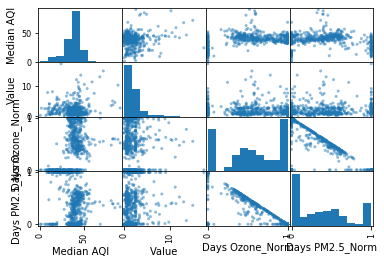

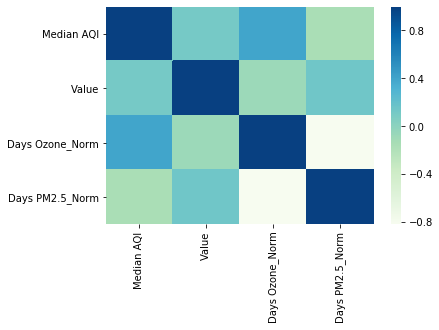

In [42]:
# Calculate 5-year averages for Input data.  Merging cancer data to air
# and water reduced the number of data entries.  The counties in each data
# set does not seem to be overlapping.  
median = air.groupby('FIPS', as_index=False)['Median AQI'].mean()
pm = air.groupby('FIPS', as_index=False)['Days PM2.5_Norm'].mean()
so2 = air.groupby('FIPS', as_index=False)['Days SO2_Norm'].mean()
co = air.groupby('FIPS', as_index=False)['Days CO_Norm'].mean()
no2 = air.groupby('FIPS', as_index=False)['Days NO2_Norm'].mean()
ozone = air.groupby('FIPS', as_index=False)['Days Ozone_Norm'].mean()
ar = water.groupby('FIPS', as_index=False)['Value'].mean()
#data = pd.merge(median, pm, on='FIPS')
data = pd.merge(median, ar, on='FIPS')
data = pd.merge(data, ozone, on='FIPS')
data = pd.merge(data, pm, on='FIPS')
#data = pd.merge(data, so2, on='FIPS')
#data = pd.merge(data, co, on='FIPS')
#data = pd.merge(data, no2, on='FIPS')
#data = pd.merge(data, ar, on='FIPS')

# Class label.
labels = cancer[['FIPS', 'Incidence Quant']][cancer['Category']=='All']

data = pd.merge(data, labels, on='FIPS')
data = data.drop('FIPS', axis=1)
data = data.dropna()

scatter_matrix(data)
plt.show()
# calculate the correlation matrix
corr = data.corr() # contains the matrix of correlation coefficients
# plot the heatmap - creates a colorful matrix 
plt.figure()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='GnBu')
plt.show()


### Hypothesis Test

#### Hypothesis 1

“We expect that as water quality decreases, cancer rates in each county will increase.”

Ttest_indResult(statistic=3.6428016000367025, pvalue=0.00028268135606476227)
intercept is  456.8501174345015
coefficient is  [-4.90896023]


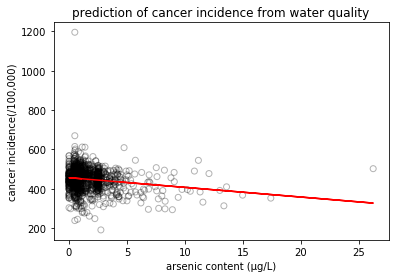

In [44]:
#############################################################################
############### hypothesis 1(t-test & linear regression) #####################
##############################################################################
def hypo1(cancer, water):
    
    cancerSubset =cancer[cancer['Group']=='Total']    
    # create aa new data frame named cancer_new
    cancer_new = pd.DataFrame(columns = ["FIPS", "cancer_incidence"]) 
    cancer_new['FIPS']=cancerSubset['FIPS']
    cancer_new['cancer_incidence']=cancerSubset['Age-Adjusted Incidence Rate(†) - cases per 100,000']
    cancer_new=cancer_new.dropna()  # drop cancer_incidence=NaN


    result_prep = water.groupby(['FIPS','County','State'])['Value'].mean()
    result_prep = result_prep.to_frame().reset_index()
    
    ######### combine two tables#######################
    water_cancer = pd.merge(result_prep, cancer_new,on="FIPS",how='inner')#### combine tables by FIPS
    
    water_cancer['cancer_incidence']=pd.to_numeric(water_cancer['cancer_incidence'])
    water_cancer['Value']=pd.to_numeric(water_cancer['Value'])
    del water_cancer['FIPS']
    del water_cancer['County']
    del water_cancer['State']
    #Now, here is a table 'water_cancer' that only contain
    # the value of arsenic in water and the cancer incident
    
    
    ## 1.t-test and linear regression
    # H0: counties with arsenic at 'non-detected' level have the same cancer rate with arsenic detected 
    water_cancer1=water_cancer[water_cancer['Value']<=1]
    water_cancer2=water_cancer[water_cancer['Value']>1]
    cancer_gw=water_cancer1['cancer_incidence']# cancer incedence of water at 'non-detected' level
    cancer_bw=water_cancer2['cancer_incidence']# cancer incedence of water at 'non-detected' level
    
    p_value=stats.ttest_ind(cancer_gw,cancer_bw, equal_var = False)
    print(p_value)
    # Here, the pvalue=0.000283, which is smaller than 0.05. 
    # So counties with arsenic at 'non-detected' level have different cancer rate with arsenic at 'detectable' level 
    
    
    # 2.Linear Regression: y=ax+b, where the x= result['value'] and y=cancer['cancer_incidence']
    x= water_cancer.iloc[:, :-1].values   # x is the arsenic_content
    y = water_cancer.iloc[:, 1].values   #y is cancer incidence
    reg = LinearRegression().fit(x, y) # fit the model
    
    print('intercept is ',reg.intercept_)
    print('coefficient is ',reg.coef_)
    #the intercept in the regression is 456.85 and the slope is -4.91
    # so the linear regression is cancer_incidence=-4.91*arsenic_content+456.85
    
    plt.scatter(x, y, facecolor='None', edgecolor='k', alpha=0.3)
    plt.title("prediction of cancer incidence from water quality")
    plt.xlabel("arsenic content (µg/L)")
    plt.ylabel("cancer incidence(/100,000)")

    plt.plot(x, reg.predict(x.reshape(-1,1)), color='red')
    plt.show()
    plt.close()

hypo1(cancer, water)

A linear regression was applied to explore the relationship between water quality and cancer rate. The scatterplot above shows arsenic content against cancer rate, and the red line in the plot describes the equation of linear regression: cancer rate=-4.91*arsenic content+456.85, which means that cancer rate would decline if water quality decreases. As the graph shows, the arsenic content of most points lay from 0 to 10µg/L. However, these points at low arsenic level between 0 and 10µg/L are not so meaningful for exploring the relationship between water quality and cancer rate. According to the research, “Long term exposure to drinking water containing arsenic at levels higher than 10 ppb increases the chances of getting cancer; for lower levels the chances are less.” We define water containing arsenic at level above 10µg/L as harmful water. Therefore, these high cancer rates at low arsenic level should be explained by factors other than water quality, such as stress, bad living habits, etc. Hence, focusing on harmful water (arsenic content>=10µg/L) would be more representative.

#### Hypothesis 2

“The air and water quality scores in each county can be used as predictors for that specific county’s cancer rate (the average number of individuals affected with cancer in each county over a five year period).”

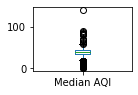

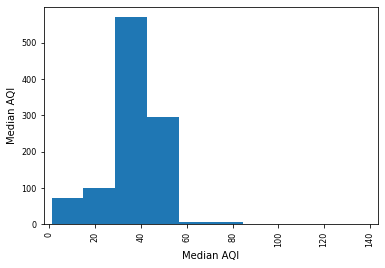

NB: 0.801961 (0.043715)
SVM: 0.796008 (0.046606)

The accuracy score for SVM is:
0.7867298578199052
[[  0   0  42]
 [  0   0   3]
 [  0   0 166]]
             precision    recall  f1-score   support

    falling       0.00      0.00      0.00        42
     rising       0.00      0.00      0.00         3
     stable       0.79      1.00      0.88       166

avg / total       0.62      0.79      0.69       211


The accuracy score for NBGaussian is:
0.7867298578199052



The random Forest hypothesis is:


C:\Users\shera\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


       Prediction
count         211
unique          3
top        stable
freq          206


In [45]:
###########################################################################
### Hypotheis 3: using SVM, NB and Random Forest
### Using water Impurity data, air quality(days) and cancer trend to predict the cancer trend.
### More impurity in water and less good days, the cancer trend will be cause more cancer rate 
def TrendHypo(cancer, water, air):
    
    cancerTotal = cancer[cancer['Group'] == 'Total']
    cancerData = cancerTotal[['FIPS','Recent Trend']]
    
    #waterTotal = water.groupby(['FIPS','County','State'])['Value'].mean()
    #waterTotal = waterTotal.to_frame().reset_index()
    # fix water data FIPS 
   # waterTotal['WaterImpurity'] = waterTotal['Value']
    #waterTotal = waterTotal.drop(['State', 'County','Value'], axis=1)
    
    
    airTotal = air.groupby(['FIPS','County','State'])['Median AQI'].mean()
    airTotal = airTotal.to_frame().reset_index()
    airTotal = airTotal.drop(['State', 'County'], axis=1)
    
    ############## Merging data into a new dataframe ############## 
    hypoData = pd.merge(airTotal, cancerData, on='FIPS',how='inner')
    #hypoData = pd.merge(waterTotal, airCancer, on='FIPS')
    hypoData = hypoData.drop(['FIPS'], axis=1)
    hypoData = hypoData.dropna()
    hypoData['Recent Trend'] = hypoData['Recent Trend'].astype('category')
    
    
    #######################################################
    ## Plot the new merging data
    #######################################################
    hypoData.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False)
    hypoGroup = hypoData.groupby(['Recent Trend'])['Median AQI'].mean()
    hypoGroup.plot.bar()
    scatter_matrix(hypoData)
    plt.show()
    plt.close()
    
    ######################################################
    # Evaluate algorithms
    ######################################################
    
    # Separate training and final validation data set. First remove class
    # label from data (X). Setup target class (Y)
    # Then make the validation set 20% of the entire
    # set of labeled data (X_validate, Y_validate)
    
    # Normalize all data
    hypotest = pd.DataFrame()
    hypotest['Median AQI'] = hypoData['Median AQI']
    #hypotest['WaterImpurity'] = hypoData['WaterImpurity']
    dt = hypotest.values
    valueArray = normalize(dt, axis=0, norm='max')
    
    
    valueArray = hypoData.values
    X = valueArray[:,0:1]
    Y = valueArray[:,1]
#    X = sklearn.preprocessing.normalize(X)
    test_size = 0.20
    seed = 7
    X_train, X_validate, Y_train, Y_validate = cross_validation.train_test_split(X, Y, test_size=test_size, random_state=seed)
    
    # Setup 10-fold cross validation to estimate the accuracy of different models
    # Split data into 10 parts
    # Test options and evaluation metric
    num_folds = 10
    num_instances = len(X_train)
    seed = 7
    scoring = 'accuracy'
    
    ######################################################
    # Use different algorithms to build models
    ######################################################
    
    # Add each algorithm and its name to the model array
    models = []
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC()))
    
    # Evaluate each model, add results to a results array,
    # Print the accuracy results (remember these are averages and std
    results = []
    names = []
    for name, model in models:
    	kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    	cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    	results.append(cv_results)
    	names.append(name)
    	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    	print(msg)
    
    
    ######################################################
    # For the best model, see how well it does on the
    # validation test. For example - this is for SVM
    ######################################################
    # Make predictions on validation dataset
    
    svm = SVC()
    svm.fit(X_train, Y_train)
    predictions = svm.predict(X_validate)
        
    
    print("\nThe accuracy score for SVM is:")
    print(accuracy_score(Y_validate, predictions))
    print(confusion_matrix(Y_validate, predictions))
    print(classification_report(Y_validate, predictions))
        
    
    print("\nThe accuracy score for NBGaussian is:")    
    nb = GaussianNB()
    nb.fit(X_train, Y_train)
    predictions_nb = nb.predict(X_validate)
    print(accuracy_score(Y_validate, predictions_nb))
    
    print("\n")
    
    
    ###### Random Forest
    
    print("\nThe random Forest hypothesis is:")  
    model = RandomForestClassifier(n_estimators=1000)
    model.fit(X_train, Y_train)
    predicted = model.predict(X_validate)
    predictedInfo = pd.DataFrame(predicted, columns=['Prediction'])
    print(predictedInfo.describe())
    
TrendHypo(cancer, water, air)